In [1]:
import torch
import torch.nn as nn
from torch.functional import  F
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import torchvision
from torchvision import transforms
import PIL
import numpy as np
import os
import xml.etree.ElementTree as ET
import matplotlib.patches as patches

# Image Segmentation

Preparando la data

In [19]:
!mkdir .kaggle
!mv kaggle.json .kaggle/
!mv .kaggle ~/

mkdir: cannot create directory ‘.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
mv: cannot move '.kaggle' to '/root/.kaggle': Directory not empty


In [65]:
!kaggle datasets download longnguyen2306/bacteria-detection-with-darkfield-microscopy
!unzip bacteria-detection-with-darkfield-microscopy.zip

bacteria-detection-with-darkfield-microscopy.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bacteria-detection-with-darkfield-microscopy.zip
  inflating: images/001.png          
  inflating: images/002.png          
  inflating: images/003.png          
  inflating: images/004.png          
  inflating: images/005.png          
  inflating: images/006.png          
  inflating: images/007.png          
  inflating: images/008.png          
  inflating: images/009.png          
  inflating: images/010.png          
  inflating: images/011.png          
  inflating: images/012.png          
  inflating: images/013.png          
  inflating: images/014.png          
  inflating: images/015.png          
  inflating: images/016.png          
  inflating: images/017.png          
  inflating: images/018.png          
  inflating: images/019.png          
  inflating: images/020.png          
  inflating: images/021.png          
  inflating

In [2]:
class SegmentationDS(torch.utils.data.Dataset):
  def __init__(self,imgs_list, masks_list,transform=transforms.ToTensor(),target_transform=transforms.PILToTensor()):
    self.imgs_list = imgs_list
    self.masks_list = masks_list
    self.transform = transform
    self.target_transform = target_transform
  def __getitem__(self, idx):
    I_org = PIL.Image.open(self.imgs_list[idx])
    I_mask = PIL.Image.open(self.masks_list[idx]).convert("L")
    if self.transform is not None:
      I_org = self.transform(I_org)
    I_mask = self.target_transform(I_mask).long()
    _, H, W = I_mask.shape
    return I_org, I_mask.view((H,W))
  def __len__(self):
    return len(self.imgs_list)

In [63]:
!mkdir bacteria
!mkdir bacteria/train
!mkdir bacteria/test
!mkdir bacteria/train/images
!mkdir bacteria/train/masks
!mkdir bacteria/test/images
!mkdir bacteria/test/masks

In [66]:
for elem in os.listdir("images"):
  p = np.random.random()
  if p < 0.1:
    os.system(f"mv images/{elem} bacteria/test/images/")
    os.system(f"mv masks/{elem} bacteria/test/masks/")
  else:
    os.system(f"mv images/{elem} bacteria/train/images/")
    os.system(f"mv masks/{elem} bacteria/train/masks/")

In [67]:
def create_segmentation_dataloader(root,batch_size=2,resize=(64,128)):
  train_root_imgs = os.path.join(root, "train/images")
  train_root_masks = os.path.join(root, "train/masks")
  test_root_imgs = os.path.join(root, "test/images")
  test_root_masks = os.path.join(root, "test/masks")

  train_imgs_list = [os.path.join(train_root_imgs, elem) for elem in os.listdir(train_root_imgs)]
  train_masks_list = [os.path.join(train_root_masks, elem) for elem in os.listdir(train_root_masks)]
  test_imgs_list = [os.path.join(test_root_imgs, elem) for elem in os.listdir(test_root_imgs)]
  test_masks_list = [os.path.join(test_root_masks, elem) for elem in os.listdir(test_root_masks)]

  transf = torchvision.transforms.Compose([
    torchvision.transforms.Resize(resize),
    torchvision.transforms.ToTensor()
  ])

  target_transf = torchvision.transforms.Compose([
    torchvision.transforms.Resize(resize),
    torchvision.transforms.PILToTensor()
  ])

  train_ds = SegmentationDS(train_imgs_list, train_masks_list,transform=transf, target_transform=target_transf)
  test_ds = SegmentationDS(test_imgs_list, test_masks_list,transform =transf, target_transform=target_transf)

  train_dl = torch.utils.data.DataLoader(train_ds,batch_size=batch_size,shuffle=True)
  test_dl = torch.utils.data.DataLoader(test_ds,batch_size=batch_size,shuffle=True)
  
  return train_dl, test_dl

Creando nuestro modelo

In [68]:
def conv_block(in_planes, out_planes, kernel_size=1,stride=1,padding=0):
  return nn.Sequential(
      nn.Conv2d(in_channels=in_planes, out_channels=out_planes,kernel_size=kernel_size,stride=stride,padding=padding,bias=False),
      nn.BatchNorm2d(out_planes),
      nn.ReLU(inplace=True)
  )

class ResBlock(nn.Module):
  def __init__(self,inplanes, outplanes,kernel_size=3,stride=1,padding=1):
    super().__init__()
    self.direct = nn.Sequential(
        nn.Conv2d(inplanes,outplanes,kernel_size=kernel_size,stride=stride,padding=padding),
        nn.BatchNorm2d(outplanes),
        nn.ReLU(inplace=True),
        nn.Conv2d(outplanes,outplanes,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(outplanes)
    )
    self.shortcut = nn.Sequential(
        nn.Conv2d(inplanes,outplanes,kernel_size=1,stride=stride),
        nn.BatchNorm2d(outplanes),
    )

    self.relu = nn.ReLU(inplace=True)
  def forward(self, x):
    return self.relu(self.direct(x) + self.shortcut(x))

def upsample_block(inplanes,outplanes):
  return nn.Sequential(
      nn.ConvTranspose2d(inplanes,outplanes,4,stride=2,padding=1),
      nn.BatchNorm2d(outplanes),
      nn.ReLU(inplace=True)
  )

In [128]:
class SegmentationModel(nn.Module):
  def __init__(self,num_classes):
    super().__init__()
    self.block1 = ResBlock(3,16,kernel_size=3,stride=2,padding=1)
    self.block2 = ResBlock(16,16)
    self.block3 = ResBlock(16,32)
    self.block4 = ResBlock(32,32)
    self.block5 = ResBlock(32,64,kernel_size=3,stride=2,padding=1)
    self.block6 = ResBlock(64,64)
    self.block7 = ResBlock(64,128)
    self.block8 = ResBlock(128,128)
    self.classifier = conv_block(128,num_classes)
  def forward(self, x):
    in_shape = x.shape
    o = self.block1(x)
    o = self.block2(o)
    o = self.block3(o)
    o = self.block4(o)
    o = self.block5(o)
    o = self.block6(o)
    o = self.block7(o)
    o = self.block8(o)
    o = self.classifier(o)
    return F.interpolate(o,in_shape[2:],mode="bilinear", align_corners=False)

In [114]:
train_dl, test_dl = create_segmentation_dataloader("./bacteria",batch_size=8,resize=(256,256))

In [93]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [129]:
fcn = SegmentationModel(3).to(dev)

Training

In [95]:
def evaluate(model, loader, crit):
  model.eval()
  avg_loss = 0
  for x, y in loader:
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
  avg_loss /= len(loader)  
  return avg_loss

def train_one_epoch(model, train_loader, crit, optim):
  model.train()
  avg_loss = 0
  for x, y in train_loader:
    optim.zero_grad()
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    loss.backward()
    optim.step()
  avg_loss /= len(train_loader)
  return avg_loss

def train(model, train_loader, test_loader, crit, optim, epochs = 20):
  for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader,crit, optim)
    test_loss = evaluate(model, test_loader, crit)
    print(f"epoch: {epoch}, train loss: {train_loss}, test loss: {test_loss}")

In [168]:
crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(fcn.parameters(),lr=0.1)
train(fcn, train_dl, test_dl, crit, optim,epochs=20)

print("----- busqueda mas fina ------")
optim = torch.optim.SGD(fcn.parameters(),lr=0.01)
train(fcn, train_dl, test_dl, crit, optim,epochs=10)

epoch: 0, train loss: 0.09839986034092449, test loss: 0.07523444890975953
epoch: 1, train loss: 0.08764815507900148, test loss: 0.07420100122690201
epoch: 2, train loss: 0.08801761145393054, test loss: 0.07603525593876839
epoch: 3, train loss: 0.08387348313061964, test loss: 0.0748300388455391
epoch: 4, train loss: 0.08274567872285843, test loss: 0.0762216366827488
epoch: 5, train loss: 0.08775600586973485, test loss: 0.07593529596924782
epoch: 6, train loss: 0.08221563102588766, test loss: 0.072367462515831
epoch: 7, train loss: 0.08139995458934988, test loss: 0.07361390963196754
epoch: 8, train loss: 0.08143251096563679, test loss: 0.07404344826936722
epoch: 9, train loss: 0.08116841413790271, test loss: 0.07327684611082078


Evaluemos nuestro modelo

In [175]:
with torch.no_grad():
  x, y = next(iter(test_dl))
  x = x.to(dev)
  y = y.to(dev)
  fcn.eval()
  o = fcn(x)
  pred = torch.argmax(o,axis=1)

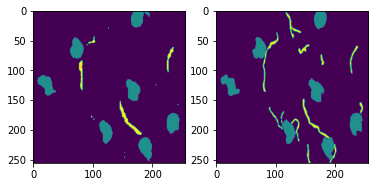

In [185]:
fig, axs = plt.subplots(1,2)
idx= 7
axs[0].imshow(pred[idx].cpu().detach().numpy())
axs[1].imshow(y[idx].cpu().detach().numpy())

In [186]:
torch.save(fcn.state_dict(),"bacteria_segmentation.ckpt")

Veamos un modelo preentrenado en COCO dataset

In [187]:
fcn_resnet50 = torchvision.models.segmentation.fcn_resnet50(pretrained=True).to(dev)
fcn_resnet50

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [188]:
transf_img = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0,0, 0], std=[1, 1, 1]),
])

In [189]:
!wget https://pytorch.org/assets/images/deeplab1.png -O image_seg.png
I = PIL.Image.open(open("image_seg.png","rb")).convert("RGB")
x = transf_img(I)
numpy_x = x.numpy()

--2022-02-10 06:37:20--  https://pytorch.org/assets/images/deeplab1.png
Resolving pytorch.org (pytorch.org)... 185.199.109.153, 185.199.110.153, 185.199.108.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2487681 (2.4M) [image/png]
Saving to: ‘image_seg.png’

image_seg.png       100%[===================>]   2.37M  --.-KB/s    in 0.06s   

2022-02-10 06:37:21 (38.7 MB/s) - ‘image_seg.png’ saved [2487681/2487681]



In [190]:
y = fcn_resnet50(x.reshape(1,*x.shape).to(dev))

In [191]:
y

OrderedDict([('out',
              tensor([[[[ 8.8951,  8.8951,  8.8951,  ...,  7.4282,  7.4282,  7.4282],
                        [ 8.8951,  8.8951,  8.8951,  ...,  7.4282,  7.4282,  7.4282],
                        [ 8.8951,  8.8951,  8.8951,  ...,  7.4282,  7.4282,  7.4282],
                        ...,
                        [10.1472, 10.1472, 10.1472,  ...,  7.5661,  7.5661,  7.5661],
                        [10.1472, 10.1472, 10.1472,  ...,  7.5661,  7.5661,  7.5661],
                        [10.1472, 10.1472, 10.1472,  ...,  7.5661,  7.5661,  7.5661]],
              
                       [[ 1.1016,  1.1016,  1.1016,  ..., -1.3539, -1.3539, -1.3539],
                        [ 1.1016,  1.1016,  1.1016,  ..., -1.3539, -1.3539, -1.3539],
                        [ 1.1016,  1.1016,  1.1016,  ..., -1.3539, -1.3539, -1.3539],
                        ...,
                        [-0.4399, -0.4399, -0.4399,  ..., -0.2319, -0.2319, -0.2319],
                        [-0.4399, -0.4399, -0

In [192]:
y1 = torch.argmax(y["out"],axis=1).cpu()

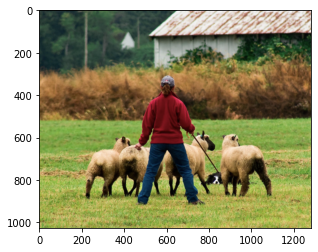

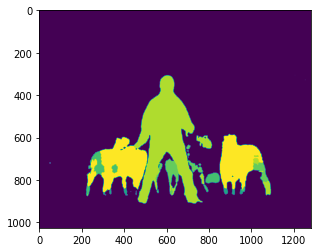

In [193]:
plt.figure(1)
plt.imshow(numpy_x.transpose(1,2,0))
plt.figure(2)
plt.imshow(y1.reshape(y1.shape[1:]).detach().numpy())

# Object Detection

In [2]:
faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn.eval()
transf_img = torchvision.transforms.ToTensor()

In [3]:
help(faster_rcnn.forward)

Help on method forward in module torchvision.models.detection.generalized_rcnn:

forward(images, targets=None) method of torchvision.models.detection.faster_rcnn.FasterRCNN instance
    Args:
        images (list[Tensor]): images to be processed
        targets (list[Dict[Tensor]]): ground-truth boxes present in the image (optional)
    
    Returns:
        result (list[BoxList] or dict[Tensor]): the output from the model.
            During training, it returns a dict[Tensor] which contains the losses.
            During testing, it returns list[BoxList] contains additional fields
            like `scores`, `labels` and `mask` (for Mask R-CNN models).



In [5]:
!wget https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt
with open("coco-labels-paper.txt","r") as f:
  coco_labels = f.readlines()

--2022-02-10 06:48:17--  https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 702 [text/plain]
Saving to: ‘coco-labels-paper.txt.2’

coco-labels-paper.t 100%[===================>]     702  --.-KB/s    in 0s      

2022-02-10 06:48:17 (33.7 MB/s) - ‘coco-labels-paper.txt.2’ saved [702/702]



In [197]:
!wget https://www.komputronik.pl/informacje/wp-content/uploads/2020/04/microsoft-365-1.jpg -O desktop.jpg
!wget https://www.telegraph.co.uk/content/dam/science/2016/11/11/shutterstock_218249854_1_trans_NvBQzQNjv4BqgsaO8O78rhmZrDxTlQBjdGLvJF5WfpqnBZShRL_tOZw.jpg -O persons_walking.jpg

--2022-02-10 06:39:31--  https://www.komputronik.pl/informacje/wp-content/uploads/2020/04/microsoft-365-1.jpg
Resolving www.komputronik.pl (www.komputronik.pl)... 104.26.2.199, 172.67.75.15, 104.26.3.199, ...
Connecting to www.komputronik.pl (www.komputronik.pl)|104.26.2.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103339 (101K) [image/jpeg]
Saving to: ‘desktop.jpg’

desktop.jpg         100%[===================>] 100.92K  --.-KB/s    in 0.01s   

2022-02-10 06:39:32 (8.65 MB/s) - ‘desktop.jpg’ saved [103339/103339]

--2022-02-10 06:39:32--  https://www.telegraph.co.uk/content/dam/science/2016/11/11/shutterstock_218249854_1_trans_NvBQzQNjv4BqgsaO8O78rhmZrDxTlQBjdGLvJF5WfpqnBZShRL_tOZw.jpg
Resolving www.telegraph.co.uk (www.telegraph.co.uk)... 104.78.233.130
Connecting to www.telegraph.co.uk (www.telegraph.co.uk)|104.78.233.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘persons_walking.jp

In [6]:
I = PIL.Image.open(open("desktop.jpg","rb"))
x = transf_img(I)

In [7]:
y = faster_rcnn(x.reshape(1,*x.shape))

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
numpy_x = x.numpy().transpose(1,2,0)

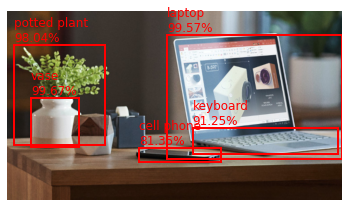

In [9]:
plt.imshow(numpy_x)
ax = plt.gca()
for i in range(5):
  box_ = y[0]["boxes"][i]
  label_ = y[0]["labels"][i].item()
  prob_ = y[0]["scores"][i].item()
  x1,y1,x2,y2 = box_.detach().numpy()
  x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
  ax.add_patch(patches.Rectangle((x1,y1),(x2-x1),(y2-y1),fill=False,linewidth=2,edgecolor="red"))
  plt.text(x1,y1-10,coco_labels[label_-1] + f"{100 * prob_:.2f}%",c="red",fontsize=12)
_= plt.axis("off")

In [205]:
!kaggle datasets download tannergi/chess-piece-detection
!unzip chess-piece-detection.zip

 99% 164M/166M [00:03<00:00, 44.6MB/s]
100% 166M/166M [00:04<00:00, 42.9MB/s]
Archive:  chess-piece-detection.zip
  inflating: Chess Detection/annotations/IMG_1989.xml  
  inflating: Chess Detection/annotations/IMG_1990.xml  
  inflating: Chess Detection/annotations/IMG_1991.xml  
  inflating: Chess Detection/annotations/IMG_1992.xml  
  inflating: Chess Detection/annotations/IMG_1993.xml  
  inflating: Chess Detection/annotations/IMG_1994.xml  
  inflating: Chess Detection/annotations/IMG_1995.xml  
  inflating: Chess Detection/annotations/IMG_1996.xml  
  inflating: Chess Detection/annotations/IMG_1997.xml  
  inflating: Chess Detection/annotations/IMG_1998.xml  
  inflating: Chess Detection/annotations/IMG_1999.xml  
  inflating: Chess Detection/annotations/IMG_2000.xml  
  inflating: Chess Detection/annotations/IMG_2001.xml  
  inflating: Chess Detection/annotations/IMG_2002.xml  
  inflating: Chess Detection/annotations/IMG_2003.xml  
  inflating: Chess Detection/annotations/IMG_2

In [10]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [11]:
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(model.roi_heads.box_predictor.cls_score.in_features,13)

In [12]:
chess_labels_ = ["white-pawn","white-rook","white-knight","white-bishop","white-queen","white-king","black-pawn","black-rook","black-knight","black-bishop","black-queen","black-king"]
chess_labels = {k: v for v,k in enumerate(chess_labels_)}

In [13]:
def get_target(xml_path):
  tree = ET.parse(os.path.join(xml_path))
  root = tree.getroot()
  boxes = []
  labels = []
  for child_obj in root:
    if child_obj.tag == "object":
      for child in child_obj:
        if child.tag == "name":
          labels.append(chess_labels[child.text])
        if child.tag == "bndbox":
          tmp = []
          for child_ in child:
            tmp.append(int(child_.text))
          boxes.append(tmp)
  boxes = torch.tensor(boxes).float()
  labels = torch.tensor(labels).long()
  return {"boxes": boxes, "labels": labels}

In [14]:
class ChessDataset(torch.utils.data.Dataset):
  def __init__(self,root, transforms):
    self.root = root
    self.transforms = transforms
    self.imgs = list(sorted(os.listdir(os.path.join(root,"images"))))
    self.annotations = list(sorted(os.listdir(os.path.join(root,"annotations"))))
    
  def __getitem__(self, idx):
    img_path = os.path.join(self.root, "images",self.imgs[idx])
    annotation_path = os.path.join(self.root, "annotations",self.annotations[idx])
    
    img = PIL.Image.open(open(img_path,"rb")).convert("RGB")
    target =  get_target(annotation_path)
    if self.transforms is not None:
      img = self.transforms(img)
    return img, target
  def __len__(self):
    return len(self.imgs)

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))
train_ds = ChessDataset("./Chess Detection/",torchvision.transforms.ToTensor())
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=2,collate_fn=collate_fn)

In [16]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
model = model.to(dev)

In [18]:
from collections import defaultdict
optim = torch.optim.SGD(model.parameters(),lr=0.005, momentum=0.9)
model.train()
N = len(train_ds)
for epoch in range(10):
  l_dict = defaultdict(lambda : 0)
  for x, y in train_dl:
    x = [x_.to(dev) for x_ in x]
    targets = [{k:v.to(dev) for k,v in y_.items()} for y_ in y]
    # print(targets)
    losses = model(x,targets)
    for k,v in losses.items():
      l_dict[k] += v.item()
    loss = sum([l for l in  losses.values()])
    optim.zero_grad()
    loss.backward()
    optim.step()
  for k,v in l_dict.items():
    l_dict[k] /= N
  print(l_dict)

defaultdict(<function <lambda> at 0x7f4e0a6fa560>, {'loss_classifier': 0.25210113172062937, 'loss_box_reg': 0.21690665194649755, 'loss_objectness': 0.0025031208739995764, 'loss_rpn_box_reg': 0.004697251165958328})
defaultdict(<function <lambda> at 0x7f4e091c6170>, {'loss_classifier': 0.19871913825656162, 'loss_box_reg': 0.11599830878369602, 'loss_objectness': 0.0011543569427414223, 'loss_rpn_box_reg': 0.00444037671219615})
defaultdict(<function <lambda> at 0x7f4e091c8ef0>, {'loss_classifier': 0.1728437818862774, 'loss_box_reg': 0.07407026054958503, 'loss_objectness': 0.0005607981720683632, 'loss_rpn_box_reg': 0.00439664020050708})
defaultdict(<function <lambda> at 0x7f4e091c17a0>, {'loss_classifier': 0.15003679490383762, 'loss_box_reg': 0.06665311578983142, 'loss_objectness': 0.00044994326753460624, 'loss_rpn_box_reg': 0.002642098920424124})
defaultdict(<function <lambda> at 0x7f4e091c8dd0>, {'loss_classifier': 0.12878775242486118, 'loss_box_reg': 0.07154956627867104, 'loss_objectness'

In [20]:
torch.save(model.cpu().state_dict(),"chess_detection.pth")

In [21]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [23]:
model = model.to(dev)

tensor([1801.9580,    0.0000, 2586.7546, 1605.4934], grad_fn=<UnbindBackward0>) black-knight


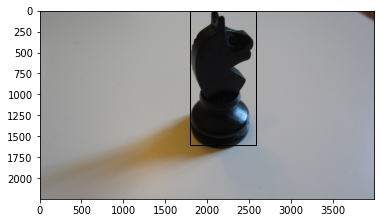

In [29]:
img = 2010
I = PIL.Image.open(open(f"./Chess Detection/images/IMG_{img}.JPG","rb")).convert("RGB")
x = torchvision.transforms.ToTensor()(I)
x = x.reshape(1,*x.shape)
y = model(x.to(dev))
boxes = y[0]["boxes"].cpu()
labels =y[0]["labels"].cpu()
scores = y[0]["scores"].cpu()
numpy_x = x.numpy()
ax = plt.gca()
plt.imshow(numpy_x.reshape(numpy_x.shape[1:]).transpose(1,2,0))
for box,label,score in zip(boxes,labels,scores):
  if score > 0.8:
    print(box,chess_labels_[label.item()])
    x1, y1, x2, y2 = box.detach().numpy()
    rect = patches.Rectangle((int(x1),int(y1)),int(x2-x1),int(y2-y1),fill=False)
    ax.add_patch(rect)